## Model Definition and Model Training (Deep Neural Network)

#### DATA DESCRIPTION

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
|date	|Date of game|
|season	|Year of season|
|team1|	 Abbreviation for home team|
|team2|	 Abbreviation for away team|
|elo1_pre	|Home team's Elo rating before the game|
|elo2_pre	|Away team's Elo rating before the game|
|elo_prob1	|Home team's probability of winning according to Elo ratings|
|elo_prob2	|Away team's probability of winning according to Elo ratings|
|elo1_post	|Home team's Elo rating after the game|
|elo2_post	|Away team's Elo rating after the game|
|qbelo1_pre	|Home team's quarterback-adjusted base rating before the game|
|qbelo2_pre	|Away team's quarterback-adjusted base rating before the game|
|qb1	|Name of home starting quarterback|
|qb2	|Name of away starting quarterback|
|qb1_value_pre	|Home starting quarterbacks's raw Elo value before the game|
|qb2_value_pre	|Away starting quarterbacks's raw Elo value before the game|
|qb1_adj	|Home starting quarterbacks's Elo adjustment for the game|
|qb2_adj	|Away starting quarterbacks's Elo adjustment for the game|
|qbelo_prob1	|Home team's probability of winning according to quarterback-adjusted Elo|
|qbelo_prob2	|Away team's probability of winning according to quarterback-adjusted Elo|
|qb1_game_value	|Home quarterback's Elo value during this game|
|qb2_game_value	|Away quarterback's Elo value during this game|
|qb1_value_post	|Home starting quarterbacks's raw Elo value after the game|
|qb2_value_post	|Away starting quarterbacks's raw Elo value after the game|
|qbelo1_post	|Home team's quarterback-adjusted base rating after the game|
|qbelo2_post	|Away team's quarterback-adjusted base rating after the game|
|score1	|Home team's score|
|score2	|Away team's score|
|quality	|Rating of game's quality, based on the harmonic mean of the teams’ pregame Elo ratings, scaled from 0-100|
|importance	|Rating of game's importance, based on how much the result would affect the model's forecasted playoff odds, scaled from 0-100|
|total_rating	|The average of quality and importance|


#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


%matplotlib inline
sns.set_style('darkgrid')
sns.set(font_scale=1.2)
#sets the default autosave frequency in seconds
%autosave 60

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential, save_model
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
# from tensorflow.keras.optimizers import Adam

#For ANN and DNN
import keras
from keras.models import save_model, load_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten
from keras.optimizers import Adam, Adagrad, RMSprop, SGD
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras.regularizers import l1,l2,l1_l2

#For Tuning
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard


import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)
pd.set_option('display.width', 1000)

np.random.seed(0)
np.set_printoptions(suppress=True)
tf.random.set_seed(0)

Autosaving every 60 seconds


In [2]:
df = pd.read_csv("nfl_elo.csv")

In [3]:
df


,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1,qb2,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating
0,1920-09-26,1920,0,NaN,RII,STP,1503.947000,1300.000000,0.824651,0.175349,1516.108000,1287.838000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,0,NaN,NaN,NaN
1,1920-10-03,1920,0,NaN,CBD,PTQ,1504.688000,1300.000000,0.825267,0.174733,1516.803000,1287.885000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,0,NaN,NaN,NaN
2,1920-10-03,1920,0,NaN,CHI,MUT,1368.333000,1300.000000,0.682986,0.317014,1386.533000,1281.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,0,NaN,NaN,NaN
3,1920-10-03,1920,0,NaN,RII,MUN,1516.108000,1478.004000,0.644171,0.355829,1542.135000,1451.977000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45,0,NaN,NaN,NaN
4,1920-10-03,1920,0,NaN,DAY,COL,1493.002000,1504.908000,0.575819,0.424181,1515.434000,1482.475000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17090,2022-01-23,2021,0,d,TB,LAR,1681.797158,1632.341105,0.659005,0.340995,1662.522916,1651.615346,1649.547292,1615.165080,Tom Brady,Matthew Stafford,249.882409,179.870436,11.456236,-0.623739,0.681440,0.318560,132.180809,379.027146,238.112249,199.786107,1629.446888,1635.265484,27,30,96.0,100.0,98.0
17091,2022-01-23,2021,0,d,KC,BUF,1699.470145,1683.332367,0.614689,0.385311,1713.932369,1668.870143,1687.450699,1656.910634,Patrick Mahomes,Josh Allen,273.771767,275.630099,20.577067,18.202487,0.652720,0.347280,622.042187,434.101420,308.598809,291.477231,1700.324756,1644.036577,42,36,100.0,100.0,100.0
17092,2022-01-30,2021,0,c,KC,CIN,1713.932369,1569.498961,0.769519,0.230481,1690.352000,1593.079331,1700.324756,1559.717895,Patrick Mahomes,Joe Burrow,308.598809,190.637925,36.961734,24.405309,0.810417,0.189583,134.683170,153.972640,291.207245,186.971396,1674.943733,1585.098917,24,27,98.0,100.0,99.0
17093,2022-01-30,2021,0,c,LAR,SF,1651.615346,1621.465562,0.633608,0.366392,1661.352751,1611.728157,1635.265484,1631.632019,Matthew Stafford,Jimmy Garoppolo,199.786107,117.398901,9.365284,-11.464001,0.636093,0.363907,248.504596,197.148060,204.657956,125.373817,1644.929010,1621.968494,20,17,96.0,100.0,98.0


In [4]:
##Get rid of the games before the first SuperBowl season 1966
df1, df2 = [x for _, x in df.groupby(df['season'] < 1966)]
df_SB = df1
df_SB

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1,qb2,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating
3821,1966-09-02,1966,0,NaN,MIA,OAK,1300.000000,1523.365000,0.286668,0.713332,1287.685000,1535.681000,1300.000000,1523.320809,Dick Wood,Cotton Davidson,73.282973,89.764573,-14.938970,1.977796,0.267553,0.732447,-182.853892,-154.440000,47.669287,65.344116,1288.586376,1534.734433,14,23,6.0,NaN,NaN
3822,1966-09-03,1966,0,NaN,TEN,DEN,1377.030000,1382.690000,0.584576,0.415424,1406.669000,1353.051000,1376.304495,1383.369283,George Blanda,Mickey Slaughter,33.816121,49.238303,-7.915569,-4.015832,0.568825,0.431175,231.294855,-55.911447,53.563994,38.723328,1407.220870,1352.452907,45,7,3.0,NaN,NaN
3823,1966-09-04,1966,0,NaN,LAC,BUF,1542.653000,1619.002000,0.483673,0.516327,1574.255000,1587.400000,1539.488456,1621.746408,John Hadl,Jack Kemp,101.310079,79.030950,1.958802,-0.888078,0.477464,0.522536,230.623604,-170.219562,114.241432,54.105899,1571.534146,1589.700719,27,7,84.0,NaN,NaN
3824,1966-09-09,1966,0,NaN,MIA,NYJ,1287.685000,1453.681000,0.358615,0.641385,1275.398000,1465.968000,1288.586376,1452.606478,Rick Norton,Mike Taliaferro,0.000000,-1.928381,-74.668152,-21.590926,0.258841,0.741159,23.029974,-31.053429,2.302997,-4.840886,1280.022162,1461.170692,14,19,0.0,NaN,NaN
3825,1966-09-10,1966,0,NaN,LAC,NE,1574.255000,1475.332000,0.719830,0.280170,1591.041000,1458.546000,1571.534146,1480.182564,John Hadl,Babe Parilli,114.241432,97.418512,8.326538,1.803571,0.688949,0.311051,105.405638,-190.768534,113.357853,68.599807,1590.375708,1461.341001,24,0,63.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17090,2022-01-23,2021,0,d,TB,LAR,1681.797158,1632.341105,0.659005,0.340995,1662.522916,1651.615346,1649.547292,1615.165080,Tom Brady,Matthew Stafford,249.882409,179.870436,11.456236,-0.623739,0.681440,0.318560,132.180809,379.027146,238.112249,199.786107,1629.446888,1635.265484,27,30,96.0,100.0,98.0
17091,2022-01-23,2021,0,d,KC,BUF,1699.470145,1683.332367,0.614689,0.385311,1713.932369,1668.870143,1687.450699,1656.910634,Patrick Mahomes,Josh Allen,273.771767,275.630099,20.577067,18.202487,0.652720,0.347280,622.042187,434.101420,308.598809,291.477231,1700.324756,1644.036577,42,36,100.0,100.0,100.0
17092,2022-01-30,2021,0,c,KC,CIN,1713.932369,1569.498961,0.769519,0.230481,1690.352000,1593.079331,1700.324756,1559.717895,Patrick Mahomes,Joe Burrow,308.598809,190.637925,36.961734,24.405309,0.810417,0.189583,134.683170,153.972640,291.207245,186.971396,1674.943733,1585.098917,24,27,98.0,100.0,99.0
17093,2022-01-30,2021,0,c,LAR,SF,1651.615346,1621.465562,0.633608,0.366392,1661.352751,1611.728157,1635.265484,1631.632019,Matthew Stafford,Jimmy Garoppolo,199.786107,117.398901,9.365284,-11.464001,0.636093,0.363907,248.504596,197.148060,204.657956,125.373817,1644.929010,1621.968494,20,17,96.0,100.0,98.0


In [5]:
df_SB.reset_index(inplace=True)

In [6]:
df_SB.fillna(0)


,index,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1,qb2,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating
0,3821,1966-09-02,1966,0,0,MIA,OAK,1300.000000,1523.365000,0.286668,0.713332,1287.685000,1535.681000,1300.000000,1523.320809,Dick Wood,Cotton Davidson,73.282973,89.764573,-14.938970,1.977796,0.267553,0.732447,-182.853892,-154.440000,47.669287,65.344116,1288.586376,1534.734433,14,23,6.0,0.0,0.0
1,3822,1966-09-03,1966,0,0,TEN,DEN,1377.030000,1382.690000,0.584576,0.415424,1406.669000,1353.051000,1376.304495,1383.369283,George Blanda,Mickey Slaughter,33.816121,49.238303,-7.915569,-4.015832,0.568825,0.431175,231.294855,-55.911447,53.563994,38.723328,1407.220870,1352.452907,45,7,3.0,0.0,0.0
2,3823,1966-09-04,1966,0,0,LAC,BUF,1542.653000,1619.002000,0.483673,0.516327,1574.255000,1587.400000,1539.488456,1621.746408,John Hadl,Jack Kemp,101.310079,79.030950,1.958802,-0.888078,0.477464,0.522536,230.623604,-170.219562,114.241432,54.105899,1571.534146,1589.700719,27,7,84.0,0.0,0.0
3,3824,1966-09-09,1966,0,0,MIA,NYJ,1287.685000,1453.681000,0.358615,0.641385,1275.398000,1465.968000,1288.586376,1452.606478,Rick Norton,Mike Taliaferro,0.000000,-1.928381,-74.668152,-21.590926,0.258841,0.741159,23.029974,-31.053429,2.302997,-4.840886,1280.022162,1461.170692,14,19,0.0,0.0,0.0
4,3825,1966-09-10,1966,0,0,LAC,NE,1574.255000,1475.332000,0.719830,0.280170,1591.041000,1458.546000,1571.534146,1480.182564,John Hadl,Babe Parilli,114.241432,97.418512,8.326538,1.803571,0.688949,0.311051,105.405638,-190.768534,113.357853,68.599807,1590.375708,1461.341001,24,0,63.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13269,17090,2022-01-23,2021,0,d,TB,LAR,1681.797158,1632.341105,0.659005,0.340995,1662.522916,1651.615346,1649.547292,1615.165080,Tom Brady,Matthew Stafford,249.882409,179.870436,11.456236,-0.623739,0.681440,0.318560,132.180809,379.027146,238.112249,199.786107,1629.446888,1635.265484,27,30,96.0,100.0,98.0
13270,17091,2022-01-23,2021,0,d,KC,BUF,1699.470145,1683.332367,0.614689,0.385311,1713.932369,1668.870143,1687.450699,1656.910634,Patrick Mahomes,Josh Allen,273.771767,275.630099,20.577067,18.202487,0.652720,0.347280,622.042187,434.101420,308.598809,291.477231,1700.324756,1644.036577,42,36,100.0,100.0,100.0
13271,17092,2022-01-30,2021,0,c,KC,CIN,1713.932369,1569.498961,0.769519,0.230481,1690.352000,1593.079331,1700.324756,1559.717895,Patrick Mahomes,Joe Burrow,308.598809,190.637925,36.961734,24.405309,0.810417,0.189583,134.683170,153.972640,291.207245,186.971396,1674.943733,1585.098917,24,27,98.0,100.0,99.0
13272,17093,2022-01-30,2021,0,c,LAR,SF,1651.615346,1621.465562,0.633608,0.366392,1661.352751,1611.728157,1635.265484,1631.632019,Matthew Stafford,Jimmy Garoppolo,199.786107,117.398901,9.365284,-11.464001,0.636093,0.363907,248.504596,197.148060,204.657956,125.373817,1644.929010,1621.968494,20,17,96.0,100.0,98.0


In [7]:
df_SB.drop(['playoff', 'team1', 'team2', 'qb1', 'qb2'],axis=1,inplace=True)

In [8]:
df_SB.drop(['index'],axis=1,inplace=True)

In [9]:
df_SB.drop(['importance', 'total_rating', 'quality'],axis=1,inplace=True)

In [10]:
df_SB.describe()

,season,neutral,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2
count,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000
mean,1995.499699,0.007232,1507.357216,1505.512618,0.582916,0.417084,1507.044885,1505.824951,1506.747153,1505.375574,99.883838,99.828062,-1.250337,-1.279654,0.575199,0.424801,112.000352,90.285273,101.095489,98.873783,1506.823204,1505.299523,22.443725,19.757496
std,15.841019,0.084737,102.386498,100.641172,0.172427,0.172427,104.898591,102.609156,98.989791,97.350296,58.474153,57.824700,25.392693,26.018196,0.177665,0.177665,133.867614,132.822829,58.856243,58.157280,101.497240,99.544718,10.559952,10.178511
min,1966.000000,0.000000,1173.652000,1166.933000,0.070953,0.029484,1166.933000,1173.652000,1171.971131,1164.327676,-53.778917,-45.310723,-242.487678,-235.050690,0.059810,0.032803,-385.737110,-413.971659,-46.329533,-53.778917,1164.327676,1181.149770,0.000000,0.000000
25%,1982.000000,0.000000,1435.276750,1435.552190,0.462004,0.286204,1433.312000,1433.750250,1437.023489,1437.567463,57.151173,57.780190,-7.937723,-7.889193,0.447634,0.286931,18.827314,-3.650329,58.083983,56.253023,1435.548325,1435.381899,14.000000,13.000000
50%,1997.000000,0.000000,1507.112500,1506.734500,0.593684,0.406316,1507.255500,1506.834500,1508.157804,1507.129299,94.060578,93.727964,2.112845,2.290435,0.586584,0.413416,110.660863,85.882879,94.483167,93.291559,1508.147398,1507.606030,22.000000,20.000000
75%,2009.000000,0.000000,1580.136500,1578.588000,0.713796,0.537996,1582.988750,1579.785840,1576.622511,1576.059612,136.382373,135.619410,12.202588,12.204918,0.713069,0.552366,202.209593,179.819857,137.563289,135.379126,1580.056751,1576.340762,29.000000,27.000000
max,2021.000000,1.000000,1839.663000,1849.484000,0.970516,0.929047,1849.484000,1831.462000,1806.390160,1814.366226,329.562716,327.716545,107.685793,107.087461,0.967197,0.940190,713.695222,605.098179,327.716545,329.562716,1814.366226,1806.223590,72.000000,62.000000


In [11]:
df_SB.corr()

,season,neutral,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2
season,1.000000,0.035474,0.032472,0.028423,0.006875,-0.006875,0.029470,0.030151,0.028724,0.025209,0.450849,0.447364,0.016179,0.008384,0.003142,-0.003142,0.185758,0.189101,0.445381,0.443513,0.026031,0.026676,0.081719,0.106911
neutral,0.035474,1.000000,0.087203,0.084955,-0.036762,0.036762,0.088234,0.080138,0.087702,0.084050,0.063596,0.060868,0.031005,0.011763,-0.028658,0.028658,0.033899,0.018943,0.064575,0.058795,0.088097,0.079586,0.013337,0.009895
elo1_pre,0.032472,0.087203,1.000000,0.062548,0.685734,-0.685734,0.978484,0.058862,0.987450,0.058368,0.482116,0.027656,0.130600,0.002805,0.669653,-0.669653,0.203312,-0.044768,0.477330,0.014524,0.965162,0.054934,0.235816,-0.175954
elo2_pre,0.028423,0.084955,0.062548,1.000000,-0.673572,0.673572,0.064294,0.977505,0.059833,0.986950,0.040068,0.455819,0.024805,0.109074,-0.634000,0.634000,-0.018025,0.188141,0.031727,0.450859,0.059936,0.963581,-0.155082,0.211868
elo_prob1,0.006875,-0.036762,0.685734,-0.673572,1.000000,-1.000000,0.668558,-0.659883,0.678520,-0.666640,0.322930,-0.308713,0.078611,-0.075328,0.958254,-0.958254,0.163234,-0.169167,0.325877,-0.314888,0.662027,-0.652219,0.284009,-0.282496
elo_prob2,-0.006875,0.036762,-0.685734,0.673572,-1.000000,1.000000,-0.668558,0.659883,-0.678520,0.666640,-0.322930,0.308713,-0.078611,0.075328,-0.958254,0.958254,-0.163234,0.169167,-0.325877,0.314888,-0.662027,0.652219,-0.284009,0.282496
elo1_post,0.029470,0.088234,0.978484,0.064294,0.668558,-0.668558,1.000000,0.017109,0.967216,0.059076,0.477946,0.017252,0.140771,-0.004789,0.658723,-0.658723,0.279756,-0.123446,0.490988,-0.012755,0.988775,0.011429,0.348319,-0.293493
elo2_post,0.030151,0.080138,0.058862,0.977505,-0.659883,0.659883,0.017109,1.000000,0.055195,0.965868,0.031759,0.457035,0.010734,0.114677,-0.627061,0.627061,-0.100806,0.266062,0.005469,0.469744,0.011017,0.988230,-0.272894,0.332274
qbelo1_pre,0.028724,0.087702,0.987450,0.059833,0.678520,-0.678520,0.967216,0.055195,1.000000,0.056239,0.464947,0.025111,0.108307,0.004494,0.675890,-0.675890,0.200613,-0.048181,0.461365,0.011466,0.977255,0.053001,0.237643,-0.177145
qbelo2_pre,0.025209,0.084050,0.058368,0.986950,-0.666640,0.666640,0.059076,0.965868,0.056239,1.000000,0.036114,0.438182,0.025511,0.085344,-0.640415,0.640415,-0.021041,0.184212,0.027506,0.434179,0.056431,0.976342,-0.156761,0.212779


In [12]:
df_SB["elo1_pre_Diff"] = df_SB["elo1_pre"].diff()

In [13]:
df_SB['elo1_pre_Diff']

0               NaN
1         77.030000
2        165.623000
3       -254.968000
4        286.570000
            ...    
13269     30.957542
13270     17.672987
13271     14.462224
13272    -62.317023
13273    -58.536016
Name: elo1_pre_Diff, Length: 13274, dtype: float64

In [14]:
df_SB.drop(['elo_prob1', 'elo_prob2', 'qb1_value_pre', 'qb2_value_pre', 'qbelo_prob1', 'qbelo_prob2', 'qb1_adj', 'qb2_adj'],axis=1,inplace=True)

In [15]:
df_SB.head()

,date,season,neutral,elo1_pre,elo2_pre,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,elo1_pre_Diff
0,1966-09-02,1966,0,1300.000,1523.365,1287.685,1535.681,1300.000000,1523.320809,-182.853892,-154.440000,47.669287,65.344116,1288.586376,1534.734433,14,23,NaN
1,1966-09-03,1966,0,1377.030,1382.690,1406.669,1353.051,1376.304495,1383.369283,231.294855,-55.911447,53.563994,38.723328,1407.220870,1352.452907,45,7,77.030
2,1966-09-04,1966,0,1542.653,1619.002,1574.255,1587.400,1539.488456,1621.746408,230.623604,-170.219562,114.241432,54.105899,1571.534146,1589.700719,27,7,165.623
3,1966-09-09,1966,0,1287.685,1453.681,1275.398,1465.968,1288.586376,1452.606478,23.029974,-31.053429,2.302997,-4.840886,1280.022162,1461.170692,14,19,-254.968
4,1966-09-10,1966,0,1574.255,1475.332,1591.041,1458.546,1571.534146,1480.182564,105.405638,-190.768534,113.357853,68.599807,1590.375708,1461.341001,24,0,286.570


In [16]:
df_SB["elo2_pre_Diff"] = df_SB["elo2_pre"].diff()
df_SB["elo1_post_Diff"] = df_SB["elo1_post"].diff()
df_SB["elo2_post_Diff"] = df_SB["elo2_post"].diff()
df_SB["qbelo1_pre_Diff"] = df_SB["qbelo1_pre"].diff()
df_SB["qbelo2_pre_Diff"] = df_SB["qbelo2_pre"].diff()
df_SB["qbelo1_post_Diff"] = df_SB["qbelo1_post"].diff()
df_SB["qbelo2_post_Diff"] = df_SB["qbelo2_post"].diff()
df_SB["qb1_game_value_Diff"] = df_SB["qb1_game_value"].diff()
df_SB["qb2_game_value_Diff"] = df_SB["qb2_game_value"].diff()
df_SB["qb1_value_post_Diff"] = df_SB["qb1_value_post"].diff()
df_SB["qb2_value_post_Diff"] = df_SB["qb2_value_post"].diff()


In [17]:
df_SB.drop(['elo1_pre', 'elo2_pre', 'elo1_post', 'elo2_post', 'qbelo1_pre', 'qbelo2_pre', 'qbelo1_post', 'qbelo2_post', 'neutral', 'score1', 'score2', 
           'qb1_game_value', 'qb2_game_value', 'qb1_value_post', 'qb2_value_post'],axis=1,inplace=True)

In [18]:
df_SB

,date,season,elo1_pre_Diff,elo2_pre_Diff,elo1_post_Diff,elo2_post_Diff,qbelo1_pre_Diff,qbelo2_pre_Diff,qbelo1_post_Diff,qbelo2_post_Diff,qb1_game_value_Diff,qb2_game_value_Diff,qb1_value_post_Diff,qb2_value_post_Diff
0,1966-09-02,1966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1966-09-03,1966,77.030000,-140.675000,118.984000,-182.630000,76.304495,-139.951526,118.634494,-182.281525,414.148747,98.528553,5.894708,-26.620788
2,1966-09-04,1966,165.623000,236.312000,167.586000,234.349000,163.183961,238.377126,164.313275,237.247812,-0.671250,-114.308115,60.677437,15.382571
3,1966-09-09,1966,-254.968000,-165.321000,-298.857000,-121.432000,-250.902080,-169.139931,-291.511984,-128.530027,-207.593631,139.166133,-111.938435,-58.946785
4,1966-09-10,1966,286.570000,21.651000,315.643000,-7.422000,282.947769,27.576086,310.353547,0.170309,82.375664,-159.715106,111.054855,73.440694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13269,2022-01-23,2021,30.957542,30.109871,30.917629,30.149785,-8.819824,6.370994,-6.082295,3.633465,86.277330,445.654855,-10.002431,82.387206
13270,2022-01-23,2021,17.672987,50.991263,51.409453,17.254796,37.903407,41.745554,70.877868,8.771093,489.861378,55.074275,70.486560,91.691124
13271,2022-01-30,2021,14.462224,-113.833406,-23.580370,-75.790812,12.874057,-97.192739,-25.381022,-58.937660,-487.359018,-280.128780,-17.391564,-104.505835
13272,2022-01-30,2021,-62.317023,51.966601,-28.999249,18.648827,-65.059271,71.914124,-30.014724,36.869577,113.821426,43.175419,-86.549289,-61.597580


In [19]:
df_SB.drop(['date'], axis=1, inplace=True)

In [20]:
df_SB

,season,elo1_pre_Diff,elo2_pre_Diff,elo1_post_Diff,elo2_post_Diff,qbelo1_pre_Diff,qbelo2_pre_Diff,qbelo1_post_Diff,qbelo2_post_Diff,qb1_game_value_Diff,qb2_game_value_Diff,qb1_value_post_Diff,qb2_value_post_Diff
0,1966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1966,77.030000,-140.675000,118.984000,-182.630000,76.304495,-139.951526,118.634494,-182.281525,414.148747,98.528553,5.894708,-26.620788
2,1966,165.623000,236.312000,167.586000,234.349000,163.183961,238.377126,164.313275,237.247812,-0.671250,-114.308115,60.677437,15.382571
3,1966,-254.968000,-165.321000,-298.857000,-121.432000,-250.902080,-169.139931,-291.511984,-128.530027,-207.593631,139.166133,-111.938435,-58.946785
4,1966,286.570000,21.651000,315.643000,-7.422000,282.947769,27.576086,310.353547,0.170309,82.375664,-159.715106,111.054855,73.440694
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13269,2021,30.957542,30.109871,30.917629,30.149785,-8.819824,6.370994,-6.082295,3.633465,86.277330,445.654855,-10.002431,82.387206
13270,2021,17.672987,50.991263,51.409453,17.254796,37.903407,41.745554,70.877868,8.771093,489.861378,55.074275,70.486560,91.691124
13271,2021,14.462224,-113.833406,-23.580370,-75.790812,12.874057,-97.192739,-25.381022,-58.937660,-487.359018,-280.128780,-17.391564,-104.505835
13272,2021,-62.317023,51.966601,-28.999249,18.648827,-65.059271,71.914124,-30.014724,36.869577,113.821426,43.175419,-86.549289,-61.597580


In [21]:
df_SB.replace(to_replace=np.nan, value=0.0, inplace=True)

In [22]:
df_SB

,season,elo1_pre_Diff,elo2_pre_Diff,elo1_post_Diff,elo2_post_Diff,qbelo1_pre_Diff,qbelo2_pre_Diff,qbelo1_post_Diff,qbelo2_post_Diff,qb1_game_value_Diff,qb2_game_value_Diff,qb1_value_post_Diff,qb2_value_post_Diff
0,1966,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1966,77.030000,-140.675000,118.984000,-182.630000,76.304495,-139.951526,118.634494,-182.281525,414.148747,98.528553,5.894708,-26.620788
2,1966,165.623000,236.312000,167.586000,234.349000,163.183961,238.377126,164.313275,237.247812,-0.671250,-114.308115,60.677437,15.382571
3,1966,-254.968000,-165.321000,-298.857000,-121.432000,-250.902080,-169.139931,-291.511984,-128.530027,-207.593631,139.166133,-111.938435,-58.946785
4,1966,286.570000,21.651000,315.643000,-7.422000,282.947769,27.576086,310.353547,0.170309,82.375664,-159.715106,111.054855,73.440694
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13269,2021,30.957542,30.109871,30.917629,30.149785,-8.819824,6.370994,-6.082295,3.633465,86.277330,445.654855,-10.002431,82.387206
13270,2021,17.672987,50.991263,51.409453,17.254796,37.903407,41.745554,70.877868,8.771093,489.861378,55.074275,70.486560,91.691124
13271,2021,14.462224,-113.833406,-23.580370,-75.790812,12.874057,-97.192739,-25.381022,-58.937660,-487.359018,-280.128780,-17.391564,-104.505835
13272,2021,-62.317023,51.966601,-28.999249,18.648827,-65.059271,71.914124,-30.014724,36.869577,113.821426,43.175419,-86.549289,-61.597580


In [23]:
df_SB.isnull().sum()

season                 0
elo1_pre_Diff          0
elo2_pre_Diff          0
elo1_post_Diff         0
elo2_post_Diff         0
qbelo1_pre_Diff        0
qbelo2_pre_Diff        0
qbelo1_post_Diff       0
qbelo2_post_Diff       0
qb1_game_value_Diff    0
qb2_game_value_Diff    0
qb1_value_post_Diff    0
qb2_value_post_Diff    0
dtype: int64

In [24]:
df_SB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13274 entries, 0 to 13273
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   season               13274 non-null  int64  
 1   elo1_pre_Diff        13274 non-null  float64
 2   elo2_pre_Diff        13274 non-null  float64
 3   elo1_post_Diff       13274 non-null  float64
 4   elo2_post_Diff       13274 non-null  float64
 5   qbelo1_pre_Diff      13274 non-null  float64
 6   qbelo2_pre_Diff      13274 non-null  float64
 7   qbelo1_post_Diff     13274 non-null  float64
 8   qbelo2_post_Diff     13274 non-null  float64
 9   qb1_game_value_Diff  13274 non-null  float64
 10  qb2_game_value_Diff  13274 non-null  float64
 11  qb1_value_post_Diff  13274 non-null  float64
 12  qb2_value_post_Diff  13274 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.3 MB


In [25]:
df_SB.describe(include='all')

,season,elo1_pre_Diff,elo2_pre_Diff,elo1_post_Diff,elo2_post_Diff,qbelo1_pre_Diff,qbelo2_pre_Diff,qbelo1_post_Diff,qbelo2_post_Diff,qb1_game_value_Diff,qb2_game_value_Diff,qb1_value_post_Diff,qb2_value_post_Diff
count,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000,13274.000000
mean,1995.499699,0.022079,0.010395,0.022382,0.010092,0.021478,0.009161,0.021718,0.008922,0.020250,0.023757,0.009733,0.010166
std,15.841019,140.658028,139.661717,144.281170,142.539071,136.143076,135.145241,139.868150,138.239154,184.140141,181.446727,70.225811,69.928244
min,1966.000000,-500.669000,-522.194000,-517.674595,-541.969000,-486.493346,-515.924208,-498.484453,-537.491824,-719.857945,-621.351805,-244.995442,-304.536144
25%,1982.000000,-96.140750,-94.218500,-98.377000,-96.236500,-91.208458,-91.629212,-94.495312,-92.743872,-125.305727,-119.941153,-46.557742,-45.940437
50%,1997.000000,-0.462500,0.125000,0.470000,-0.282000,-0.206789,-0.745499,1.275939,-0.597411,-2.239151,-0.571021,-0.288470,-0.481436
75%,2009.000000,94.124000,93.360484,97.549250,96.221500,90.312587,91.519883,94.122837,93.550254,123.877444,120.382166,45.587676,46.343729
max,2021.000000,532.221000,494.197000,509.026000,516.413000,510.562390,483.570236,488.023979,505.917717,670.037667,825.819751,300.119033,284.097311


In [26]:
df_SB.shape

(13274, 13)

In [27]:
df_SB.to_csv('NFLtraining_ELOs.csv', index=False)

### Data Visualization

#### Unvariate Data Exploration (Difference Method)

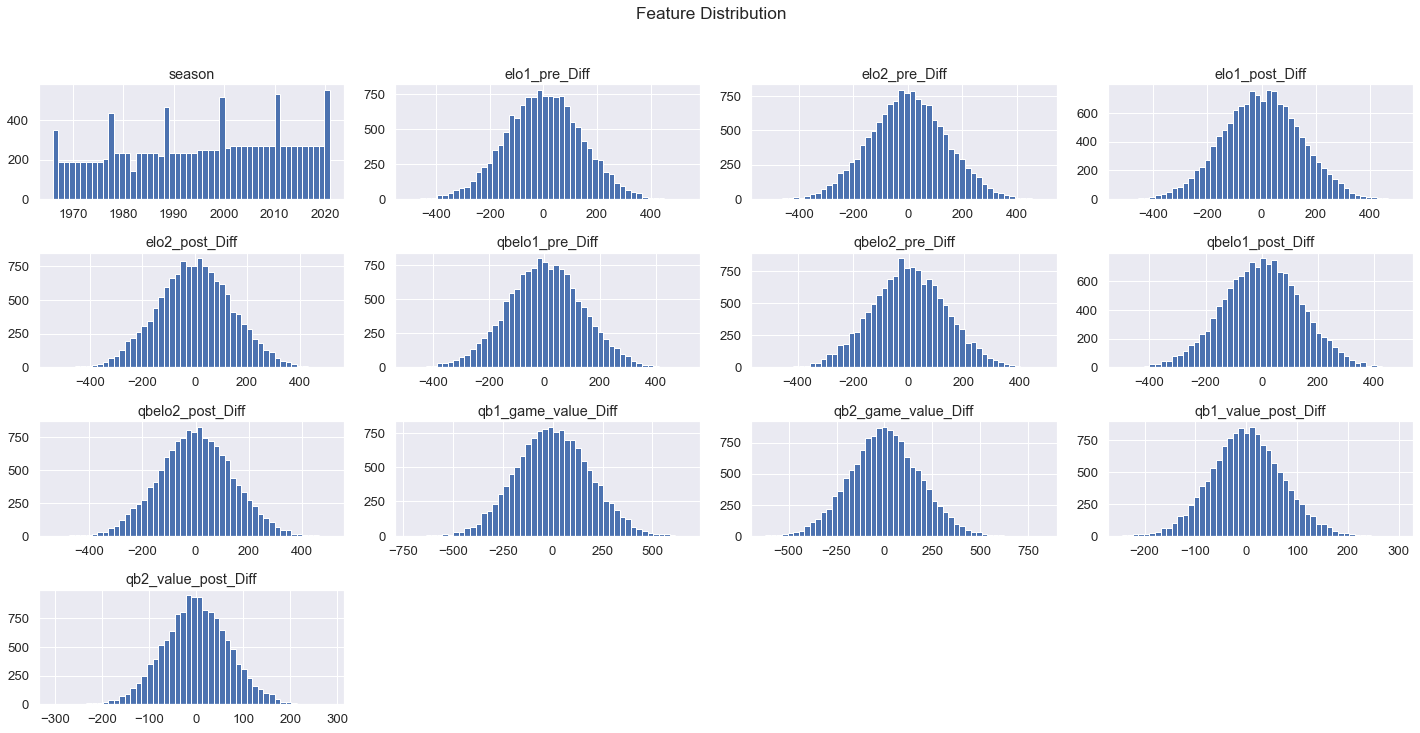

In [28]:
df_SB.hist(bins=50, figsize=(20,10))
plt.suptitle('Feature Distribution', x=0.5, y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

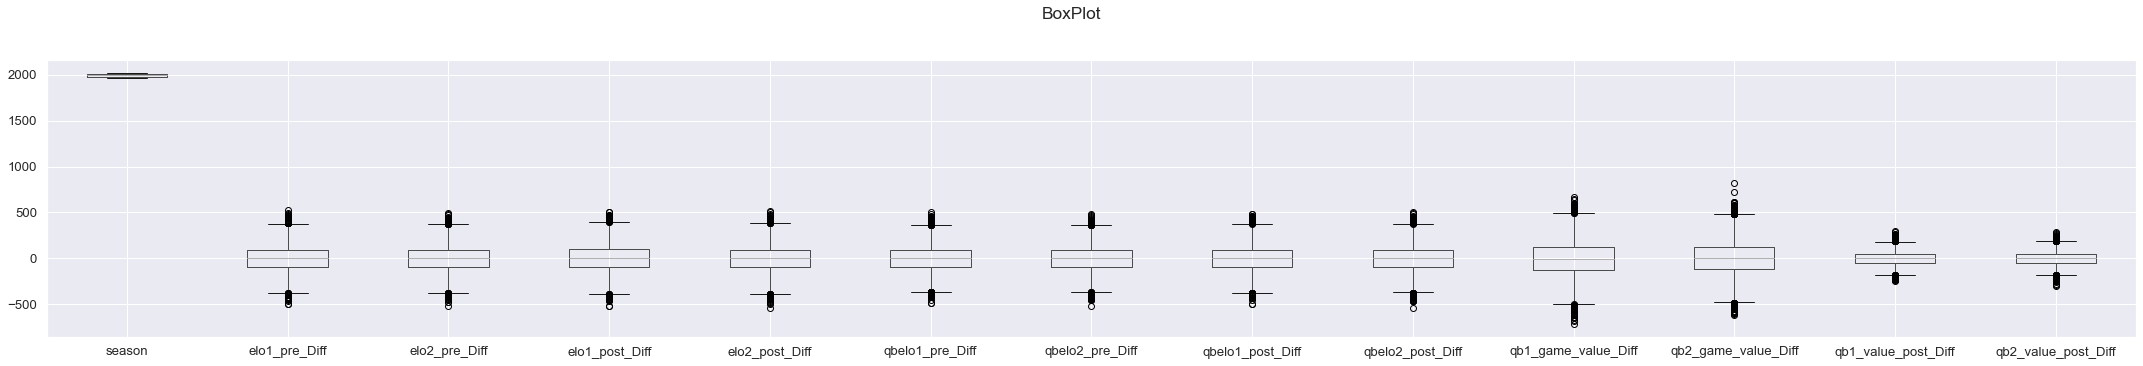

In [29]:
df_SB.boxplot(figsize=(30,5))
plt.suptitle('BoxPlot', x=0.5, y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

<Figure size 1440x1440 with 0 Axes>

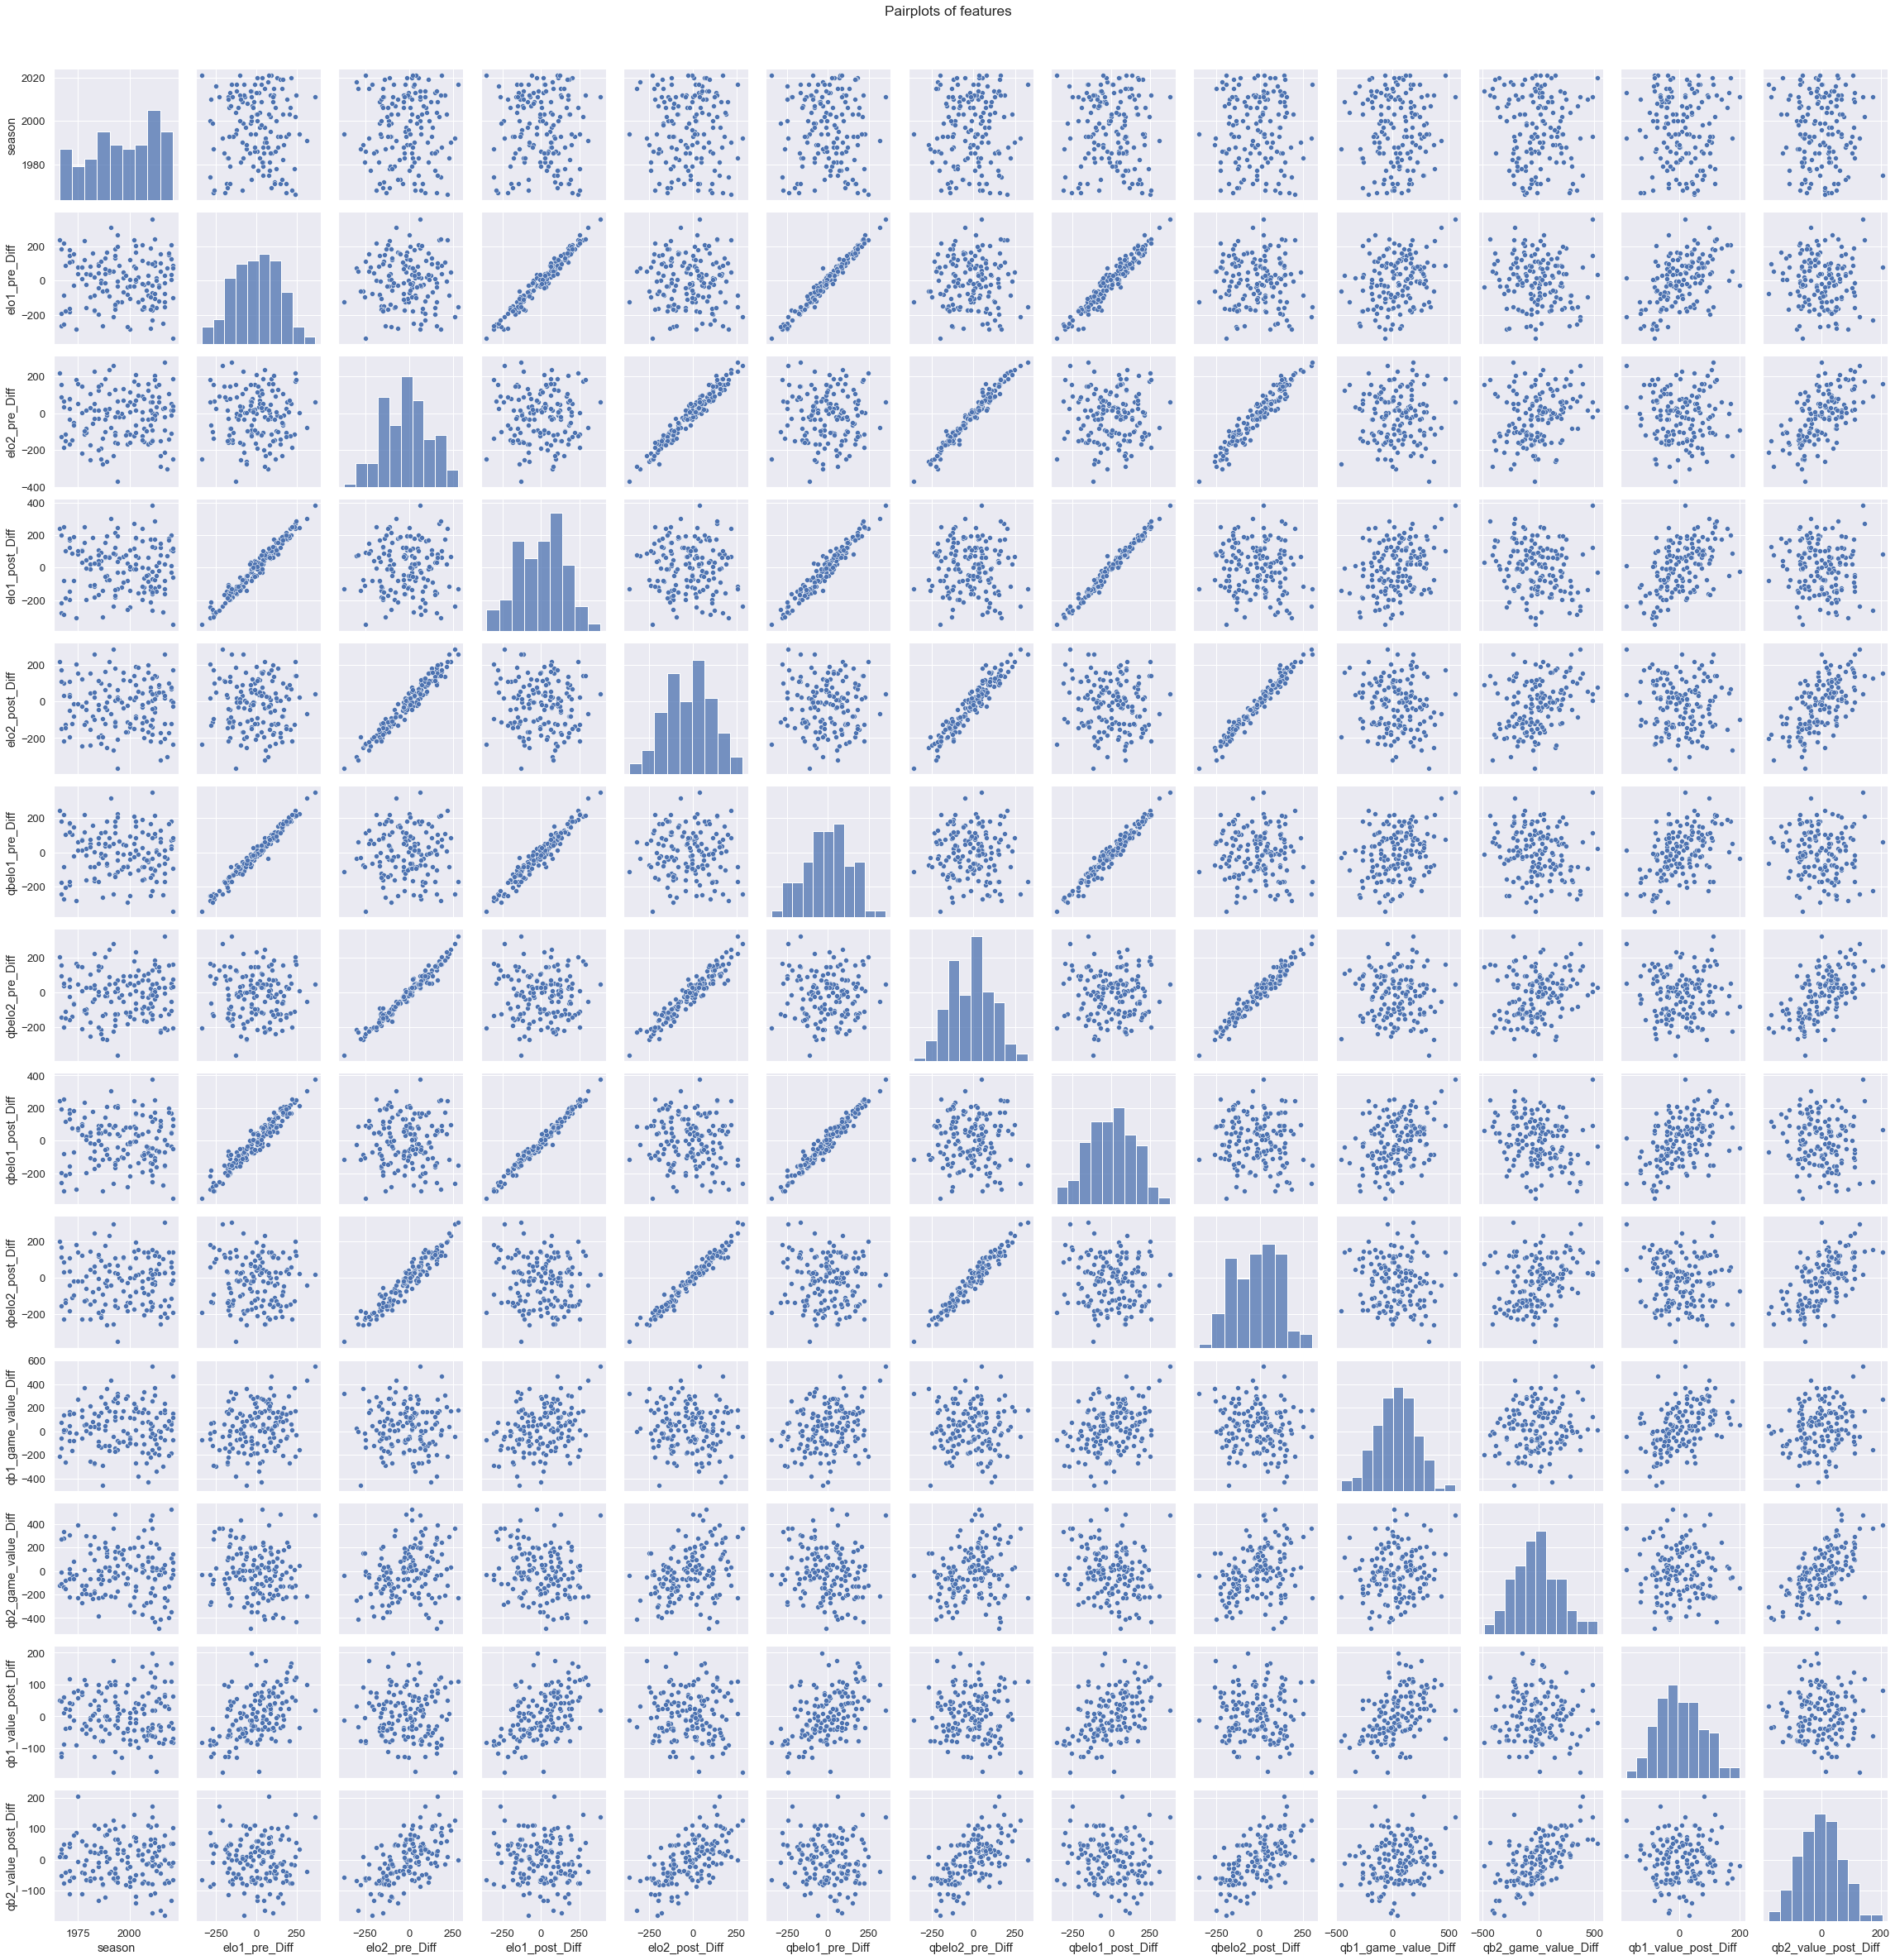

In [30]:
plt.figure(figsize=(20,20))
sns.pairplot(df_SB.sample(150))
plt.suptitle('Pairplots of features', x=0.5, y=1.02, ha='center', fontsize='large')
plt.show()

In [31]:
df_SB.corr()

,season,elo1_pre_Diff,elo2_pre_Diff,elo1_post_Diff,elo2_post_Diff,qbelo1_pre_Diff,qbelo2_pre_Diff,qbelo1_post_Diff,qbelo2_post_Diff,qb1_game_value_Diff,qb2_game_value_Diff,qb1_value_post_Diff,qb2_value_post_Diff
season,1.000000,-0.000496,-0.000219,-0.000510,-0.000188,-0.000504,-0.000225,-0.000516,-0.000194,-0.000332,-0.000170,-0.000156,-0.000063
elo1_pre_Diff,-0.000496,1.000000,0.026160,0.977453,0.023036,0.986461,0.020779,0.963256,0.017211,0.195486,-0.066776,0.526611,-0.018008
elo2_pre_Diff,-0.000219,0.026160,1.000000,0.028388,0.976893,0.023331,0.986280,0.024433,0.962462,-0.020960,0.190890,0.008769,0.515541
elo1_post_Diff,-0.000510,0.977453,0.028388,1.000000,-0.019853,0.965240,0.022234,0.987954,-0.027255,0.277203,-0.148128,0.546336,-0.045310
elo2_post_Diff,-0.000188,0.023036,0.976893,-0.019853,1.000000,0.019265,0.964370,-0.025545,0.987606,-0.108222,0.271081,-0.024760,0.533228
qbelo1_pre_Diff,-0.000504,0.986461,0.023331,0.965240,0.019265,1.000000,0.019010,0.976193,0.015725,0.194440,-0.070994,0.509798,-0.018688
qbelo2_pre_Diff,-0.000225,0.020779,0.986280,0.022234,0.964370,0.019010,1.000000,0.020480,0.975620,-0.022107,0.186882,0.006878,0.495834
qbelo1_post_Diff,-0.000516,0.963256,0.024433,0.987954,-0.025545,0.976193,0.020480,1.000000,-0.030371,0.276661,-0.153236,0.522567,-0.039496
qbelo2_post_Diff,-0.000194,0.017211,0.962462,-0.027255,0.987606,0.015725,0.975620,-0.030371,1.000000,-0.110042,0.267824,-0.019934,0.506294
qb1_game_value_Diff,-0.000332,0.195486,-0.020960,0.277203,-0.108222,0.194440,-0.022107,0.276661,-0.110042,1.000000,0.053574,0.522412,0.017915


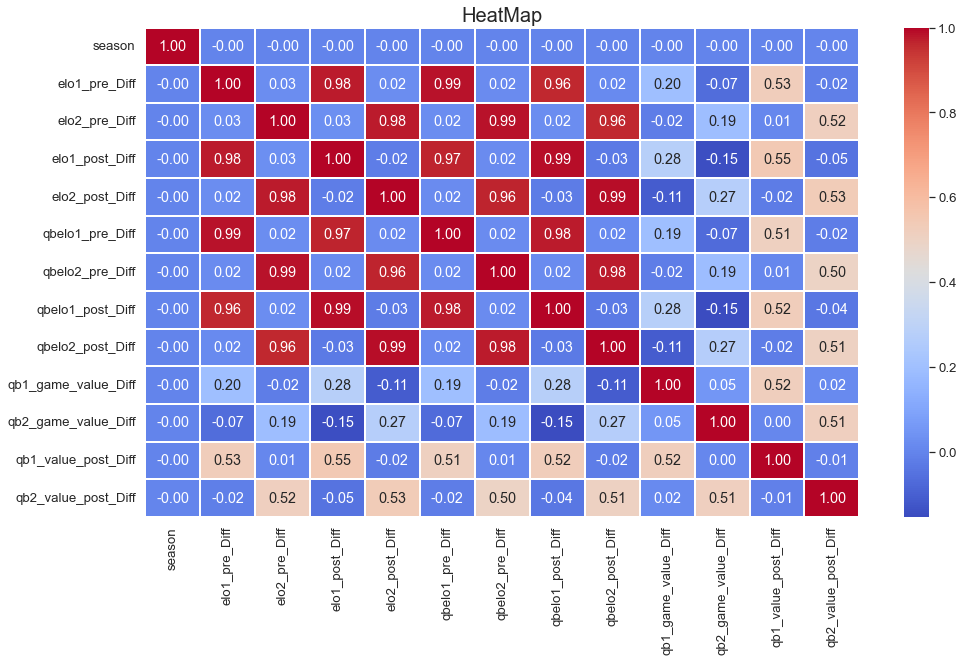

In [32]:
plt.figure(figsize=(16,9))
sns.heatmap(df_SB.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.title("HeatMap", fontsize=20)
plt.show()

### Train Test Split

In [33]:
X = df_SB.iloc[:,0:12]
y = df_SB.iloc[:,12]

In [34]:
X.values, y.values

(array([[1966.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [1966.        ,   77.03      , -140.675     , ...,  414.14874705,
           98.52855319,    5.89470765],
        [1966.        ,  165.623     ,  236.312     , ...,   -0.67125032,
         -114.30811507,   60.6774375 ],
        ...,
        [2021.        ,   14.46222447, -113.83340626, ..., -487.35901751,
         -280.12878001,  -17.39156387],
        [2021.        ,  -62.31702294,   51.96660089, ...,  113.82142621,
           43.17541937,  -86.54928912],
        [2021.        ,  -58.53601593,   39.88718927, ..., -162.5576483 ,
          -36.23275737,  -27.78900416]]),
 array([   0.        ,  -26.62078806,   15.38257102, ..., -104.50583473,
         -61.59757975,   74.90987373]))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.25, random_state=0)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9955, 12), (3319, 12), (9955,), (3319,))

#### Feature Scaling (If not using Batch Normalization)

In [37]:
X_train

array([[2004.        ,  363.918     ,  -32.614     , ...,  259.32381523,
         -25.11545375,  102.04045118],
       [1992.        ,   79.486     ,   54.923     , ..., -116.97438312,
         -62.59006791,   12.3492457 ],
       [1972.        ,  125.496     , -187.785     , ..., -136.16035112,
        -195.60409313,   15.89902236],
       ...,
       [2009.        , -115.733     ,  -35.444     , ..., -311.64680481,
        -132.87611161,  -55.51420004],
       [2012.        ,  119.926     ,  -13.856     , ...,  -41.58394884,
         212.51047536,  106.07485652],
       [1979.        , -250.885     ,  -86.959     , ..., -331.53399687,
         -44.35328542, -146.65812352]])

In [38]:
y_train

array([-18.27286063, -66.09465953,  19.96575356, ..., -40.81740467,
        41.09714788, -38.58363493])

In [39]:
minmax = MinMaxScaler()

In [40]:
X_train_scaled = minmax.fit_transform(X_train)

In [41]:
X_test_scaled = minmax.transform(X_test)

In [42]:
X_train_scaled

array([[0.69090909, 0.83164683, 0.49308038, ..., 0.70450022, 0.44374773,
        0.63662938],
       [0.47272727, 0.54713004, 0.58124325, ..., 0.43376176, 0.41585732,
        0.47209293],
       [0.10909091, 0.59315376, 0.33679994, ..., 0.41995787, 0.31686189,
        0.47860491],
       ...,
       [0.78181818, 0.35185285, 0.49023014, ..., 0.29369914, 0.36354707,
        0.34759899],
       [0.83636364, 0.5875821 , 0.51197249, ..., 0.48800355, 0.62060036,
        0.64403041],
       [0.23636364, 0.21666056, 0.43834682, ..., 0.27939073, 0.42943001,
        0.18039755]])

In [43]:
X_test_scaled

array([[0.03636364, 0.38147168, 0.56136815, ..., 0.61777644, 0.67159585,
        0.46904671],
       [0.98181818, 0.59531151, 0.51405164, ..., 0.57228892, 0.54574967,
        0.65163556],
       [0.74545455, 0.30561107, 0.37003991, ..., 0.6520449 , 0.24673267,
        0.33880703],
       ...,
       [0.05454545, 0.52668595, 0.18394482, ..., 0.5899208 , 0.41894751,
        0.16492403],
       [0.96363636, 0.48796668, 0.65941625, ..., 0.61374539, 0.40477824,
        0.45804968],
       [0.25454545, 0.31794675, 0.48394956, ..., 0.57701196, 0.384625  ,
        0.36592308]])

### Model Training

#### DNN

In [44]:
model = Sequential()
model.add(Dense(units=100,activation='relu',input_dim=12))
model.add(Dense(units=100,activation='relu',kernel_regularizer='l2'))
model.add(Dense(units=1,activation='linear'))

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1300      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 11,501
Trainable params: 11,501
Non-trainable params: 0
_________________________________________________________________


In [46]:
checkpointcb = keras.callbacks.ModelCheckpoint("BestModelPartB.h5",save_best_only=True)

In [47]:
earlystoppingcb = keras.callbacks.EarlyStopping(patience=10, verbose=1)

In [48]:
optimizer = Adam(learning_rate=0.00001)

In [49]:
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=["mse"])

In [50]:
model_history = model.fit(X_train_scaled, y_train,epochs=3000,
                          validation_split=0.2, verbose=2, callbacks=[checkpointcb,earlystoppingcb])

Epoch 1/3000
249/249 - 1s - loss: 4856.6123 - mse: 4855.6064 - val_loss: 4969.5898 - val_mse: 4968.5942 - 1s/epoch - 4ms/step
Epoch 2/3000
249/249 - 0s - loss: 4854.3955 - mse: 4853.4077 - val_loss: 4967.1025 - val_mse: 4966.1245 - 421ms/epoch - 2ms/step
Epoch 3/3000
249/249 - 0s - loss: 4852.2666 - mse: 4851.2979 - val_loss: 4964.6235 - val_mse: 4963.6636 - 417ms/epoch - 2ms/step
Epoch 4/3000
249/249 - 0s - loss: 4850.0381 - mse: 4849.0879 - val_loss: 4962.0127 - val_mse: 4961.0703 - 433ms/epoch - 2ms/step
Epoch 5/3000
249/249 - 0s - loss: 4847.7417 - mse: 4846.8052 - val_loss: 4959.2495 - val_mse: 4958.3213 - 339ms/epoch - 1ms/step
Epoch 6/3000
249/249 - 0s - loss: 4845.3457 - mse: 4844.4268 - val_loss: 4956.4165 - val_mse: 4955.5039 - 326ms/epoch - 1ms/step
Epoch 7/3000
249/249 - 0s - loss: 4842.6372 - mse: 4841.7329 - val_loss: 4953.2524 - val_mse: 4952.3579 - 362ms/epoch - 1ms/step
Epoch 8/3000
249/249 - 0s - loss: 4839.7500 - mse: 4838.8589 - val_loss: 4950.0186 - val_mse: 4949.1

In [51]:
model_history.params

{'verbose': 2, 'epochs': 3000, 'steps': 249}

In [52]:
model_history.history

{'loss': [4856.6123046875,
  4854.3955078125,
  4852.2666015625,
  4850.0380859375,
  4847.74169921875,
  4845.345703125,
  4842.63720703125,
  4839.75,
  4836.75146484375,
  4833.6455078125,
  4830.4609375,
  4827.2646484375,
  4824.01953125,
  4820.68896484375,
  4817.2470703125,
  4813.64697265625,
  4809.92578125,
  4805.9404296875,
  4801.78369140625,
  4797.45849609375,
  4792.75830078125,
  4787.9453125,
  4783.07568359375,
  4778.0634765625,
  4772.96337890625,
  4767.77001953125,
  4762.45703125,
  4757.02197265625,
  4751.4208984375,
  4745.7587890625,
  4739.96630859375,
  4734.048828125,
  4727.97509765625,
  4721.65869140625,
  4715.16357421875,
  4708.4677734375,
  4701.5693359375,
  4694.44970703125,
  4687.12451171875,
  4679.61669921875,
  4672.00146484375,
  4664.30224609375,
  4656.4033203125,
  4648.4384765625,
  4640.22265625,
  4631.66845703125,
  4622.93896484375,
  4614.0380859375,
  4605.11865234375,
  4596.0556640625,
  4586.9345703125,
  4577.69140625,
  4568

In [53]:
hist = pd.DataFrame(model_history.history)
hist

,loss,mse,val_loss,val_mse
0,4856.612305,4855.606445,4969.589844,4968.594238
1,4854.395508,4853.407715,4967.102539,4966.124512
2,4852.266602,4851.297852,4964.623535,4963.663574
3,4850.038086,4849.087891,4962.012695,4961.070312
4,4847.741699,4846.805176,4959.249512,4958.321289
...,...,...,...,...
633,2754.615479,2750.464844,2694.340820,2690.189697
634,2754.425049,2750.272461,2694.830566,2690.677490
635,2754.198975,2750.046631,2692.633545,2688.479004
636,2753.915771,2749.760986,2692.535645,2688.378906


In [54]:
hist['epoch'] = model_history.epoch

In [55]:
hist

,loss,mse,val_loss,val_mse,epoch
0,4856.612305,4855.606445,4969.589844,4968.594238,0
1,4854.395508,4853.407715,4967.102539,4966.124512,1
2,4852.266602,4851.297852,4964.623535,4963.663574,2
3,4850.038086,4849.087891,4962.012695,4961.070312,3
4,4847.741699,4846.805176,4959.249512,4958.321289,4
...,...,...,...,...,...
633,2754.615479,2750.464844,2694.340820,2690.189697,633
634,2754.425049,2750.272461,2694.830566,2690.677490,634
635,2754.198975,2750.046631,2692.633545,2688.479004,635
636,2753.915771,2749.760986,2692.535645,2688.378906,636


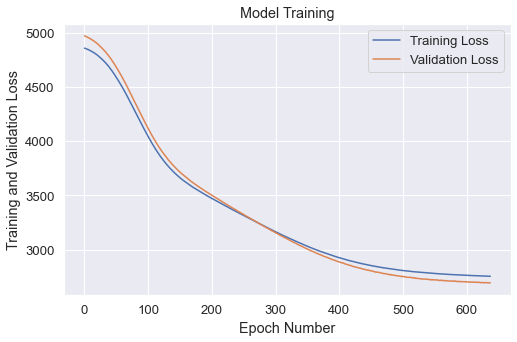

In [56]:
plt.figure(figsize=(8,5))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title("Model Training")
plt.ylabel("Training and Validation Loss")
plt.xlabel("Epoch Number")
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

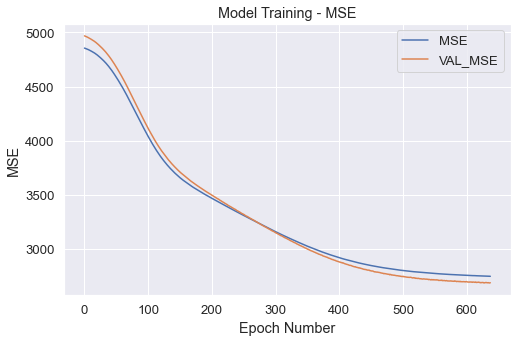

In [57]:
plt.figure(figsize=(8,5))
plt.plot(model_history.history['mse'])
plt.plot(model_history.history['val_mse'])
plt.title("Model Training - MSE")
plt.ylabel("MSE")
plt.xlabel("Epoch Number")
plt.legend(['MSE','VAL_MSE'])
plt.show()

#### Model Evaluation

In [58]:
model.get_weights()

[array([[-0.0962968 , -0.05485016,  0.08446168, ..., -0.03266584,
          0.13759811, -0.14118391],
        [ 0.07700419,  0.04515289, -0.0966616 , ...,  0.09945584,
         -0.16706385, -0.10401379],
        [ 0.0436691 , -0.05591663,  0.18055639, ..., -0.19453904,
          0.3239889 ,  0.05098757],
        ...,
        [-0.13624203, -0.01491837, -0.09609856, ...,  0.22201867,
          0.23709598,  0.07666282],
        [ 0.14044374, -0.20180388,  0.28551117, ..., -0.19139303,
          0.3756281 , -0.18126528],
        [-0.06559117,  0.2236542 ,  0.05675462, ..., -0.12629206,
         -0.11946162,  0.19351307]], dtype=float32),
 array([ 0.        ,  0.3407738 , -0.18485193,  0.47626305,  0.        ,
        -0.23079744,  0.        ,  0.30258676,  0.31471553, -0.00144448,
         0.        ,  0.33324146, -0.1442614 ,  0.        , -0.23633175,
        -0.21517304,  0.3583214 , -0.24441756, -0.21202353, -0.14380676,
        -0.22124696,  0.        , -0.22742362,  0.4888103 , -0.184

In [59]:
test_loss, test_mse = model.evaluate(X_test_scaled,y_test)

104/104 [==============================] - 0s 922us/step - loss: 2758.3770 - mse: 2754.2188


In [60]:
print("Test MSE: {}".format(test_mse))

Test MSE: 2754.21875


#### Model Prediction

In [61]:
y_pred = model.predict(X_test_scaled)

104/104 [==============================] - 0s 785us/step


In [62]:
y_pred[0:5]

array([[ 48.68011  ],
       [  7.1847816],
       [-82.66432  ],
       [-37.202976 ],
       [ 73.87456  ]], dtype=float32)

In [63]:
y_pred.round()[0:5]

array([[ 49.],
       [  7.],
       [-83.],
       [-37.],
       [ 74.]], dtype=float32)

In [64]:
y_test[0:5]

array([ 10.74958916, -19.07088438, -70.84162723,  10.57357382,
        20.42444541])

In [65]:
mse = mean_squared_error(y_test,y_pred.round())
mse

2754.4432665241584

In [66]:
rmse = np.sqrt(mse)
rmse

52.482790193778364

In [67]:
r2 = r2_score(y_test,y_pred.round())
r2

0.4407660481659358

In [68]:
n = len(X_test)
n

3319

In [69]:
p = X_test.shape[1]
p

12

In [70]:
#Adjusted R2 Score
adjr2 = 1-(1-r2)*(n-1)/(n-p-1)
adjr2

0.4387361608634528

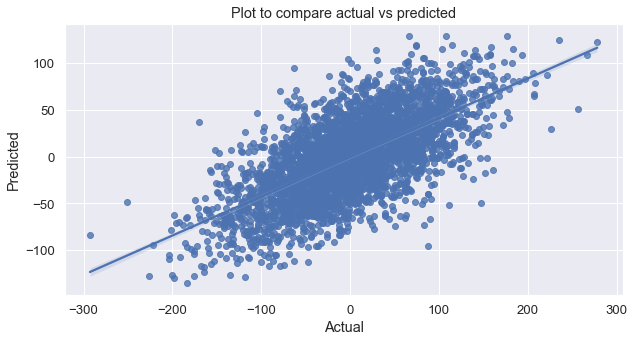

In [71]:
fig, ax = plt.subplots(figsize=(10,5))
sns.regplot(x=y_test, y=y_pred.round(), ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

In [72]:
model.save("dnnPartB.h5")

#### Cross Validation (KerasREgressor or Classifier)

In [73]:
def build_regressor(optimizer):
    model = Sequential()
    model.add(Dense(units=100,activation='relu',input_dim=12))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    model.add(Dense(units=100,activation='relu',kernel_regularizer='l2'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    model.add(Dense(units=1,activation='linear'))
    optimizer = Adam(learning_rate=0.00001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=["mse"])
    return model

In [74]:
model = KerasRegressor(build_fn=build_regressor)

In [75]:
params = {'batch_size':[1,2,5],
          'epochs' : [100,200,300],
          'optimizer' : ['Adam', 'RMSprop', 'SGD']
         }

In [76]:
randomsearch = RandomizedSearchCV(estimator=model, param_distributions=params,n_iter=10,
                                  scoring='neg_root_mean_squared_error',n_jobs=-1,cv=5,random_state=0)

In [ ]:
randomsearchcv = randomsearch.fit(X_train, y_train)

In [ ]:
randomsearchcv.best_params_

In [ ]:
randomsearchcv.best_score_

#### FINAL MODEL

In [77]:
model2 = Sequential()
model2.add(Dense(units=100,activation='relu',input_dim=12))
#model2.add(BatchNormalization())
#model2.add(Dropout(0.2))
model2.add(Dense(units=100,activation='relu',kernel_regularizer='l2'))
#model2.add(BatchNormalization())
#model2.add(Dropout(0.2))
model2.add(Dense(units=1,activation='linear'))

In [78]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               1300      
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 11,501
Trainable params: 11,501
Non-trainable params: 0
_________________________________________________________________


In [79]:
checkpointcb = keras.callbacks.ModelCheckpoint("BestModelPartA.h5",save_best_only=True)

In [80]:
earlystoppingcb = keras.callbacks.EarlyStopping(patience=10, verbose=1)

In [81]:
optimizer = SGD(learning_rate=0.0001)

In [82]:
model2.compile(optimizer=optimizer, loss='mean_squared_error', metrics=["mse"])

In [83]:
model_history_2 = model2.fit(X_train, y_train,epochs=200,batch_size=2,
                          validation_split=0.2, verbose=2, callbacks=[checkpointcb,earlystoppingcb])

Epoch 1/200
3982/3982 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 1ms/step
Epoch 2/200
3982/3982 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 908us/step
Epoch 3/200
3982/3982 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 945us/step
Epoch 4/200
3982/3982 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 928us/step
Epoch 5/200
3982/3982 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 959us/step
Epoch 6/200
3982/3982 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 911us/step
Epoch 7/200
3982/3982 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 922us/step
Epoch 8/200
3982/3982 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 1ms/step
Epoch 9/200
3982/3982 - 4s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 4s/epoch - 1ms/step
Epoch 10/200
3982/3982 - 6s - loss: nan - mse: nan - val_loss

In [84]:
model_history_2.params

{'verbose': 2, 'epochs': 200, 'steps': 3982}

In [85]:
model2.save("dnnPartA.h5")